In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import bbknn
import os
from scipy import sparse

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
adata = sc.read_h5ad('/home/HardDrives/Drive2/BCELL_TFs/ANALYSIS/SPATIAL_PAPER_SLO_INTEGRATION/sc.h5ad')
adata

AnnData object with n_obs × n_vars = 73260 × 10237
    obs: 'Age', 'BCELL_CLONE', 'BCELL_CLONE_SIZE', 'Donor', 'ID', 'IGH_MU_FREQ', 'ISOTYPE', 'LibraryID', 'Method', 'Population', 'PrelimCellType', 'Sample', 'Sex', 'Study', 'Tissue', 'barcode', 'batch', 'doublet_score', 'index', 'predicted_doublet', 'percent_mito', 'n_counts', 'n_genes', 'S_score', 'G2M_score', 'phase', 'VDJsum', 'cell_cycle_diff', 'PrelimCellType_new', 'leiden', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'CellType', 'CellType2', 'Subset', 'Subset_Broad', 'Subset_all', 'new_celltype', 'Subset_int', 'Subset_print'
    var: 'GeneID-2', 'GeneName-2', 'feature_types', 'feature_types-0', 'feature_types-1', 'gene_ids-1', 'gene_ids-4861STDY7135913-0', 'gene_ids-4861STDY7135914-0', 'gene_ids-4861STDY7208412-0', 'gene_ids-4861STDY7208413-0', 'gene_ids-Human_colon_16S7255677-0', 'gene_ids-Human_colon_16S7255678-0', 'gene_ids-Human_colon_16S8000484-0', 'gene_ids-Pan_T7935494-0', 'genome-1', 'n_cells', 'nonz_mean', 'mean_cov_

In [ ]:
#list(adata.obs['Subset'].value_counts().index)

In [64]:
adata.obs['Subset'].cat.reorder_categories([
'B_IFN',
'B_naive',
'B_activated',
'B_preGC',
'B_GC_LZ',
'B_GC_DZ',
'B_Cycling',
'B_GC_prePB',
'B_plasma',
'B_mem',    

'T_CD4+',
'T_CD4+_TfH',
'T_CD4+_TfH_GC',
'T_Treg',
'T_TfR',
'T_TIM3+',
'T_CD4+_naive',
'T_CD8+_naive',
'T_CD8+_cytotoxic',
'T_CD8+_CD161+',
'NKT',
'NK',
'ILC',
'DC_pDC',
'DC_cDC1',
'DC_cDC2',
'DC_CCR7+',
'Monocytes',
'Macrophages_M1',
'Macrophages_M2',
'Mast',
'Endo',
'FDC',
'VSMC'],inplace=True)

/home/hamish/miniconda3/envs/scvelo/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


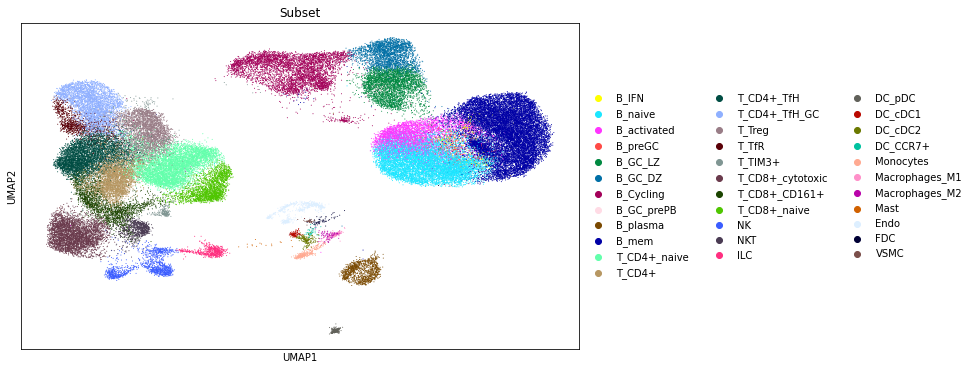

In [13]:
plt.rcParams['figure.figsize'] = [10, 6]
sc.pl.umap(adata, color=['Subset'], size=4)

## Identify marker genes

In [6]:
sc.tl.dendrogram(adata, groupby="Subset")

In [7]:
sc.tl.rank_genes_groups(adata, 'Subset')

/home/hamish/miniconda3/envs/scvelo/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
/home/hamish/miniconda3/envs/scvelo/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:404: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


In [8]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,B_IFN,B_naive,B_mem,B_activated,B_preGC,B_GC_LZ,B_GC_DZ,B_Cycling,B_GC_prePB,B_plasma,...,DC_cDC1,DC_cDC2,DC_CCR7+,Monocytes,Macrophages_M1,Macrophages_M2,Mast,Endo,FDC,VSMC
0,HLA-DPB1,HLA-DRA,HLA-DRA,CD74,HLA-DRB1,MS4A1,SERF2,HMGB1,VPREB3,SSR4,...,LGALS2,TMSB10,TMSB10,TYROBP,AIF1,AIF1,KIT,IFITM3,FDCSP,CALD1
1,CD74,FCER2,BANK1,CD83,MS4A1,HLA-DRB1,CD79B,GAPDH,LAPTM5,MZB1,...,AIF1,HLA-DPB1,MARCKSL1,FTH1,LYZ,HCK,IL1RL1,GNG11,MDK,IGFBP7
2,HLA-DRA,HVCN1,HLA-DPB1,HLA-DPA1,HLA-DQA1,LRMP,TCL1A,H2AFZ,CD79A,FKBP11,...,SNX3,HLA-DPA1,GSTP1,AIF1,TMEM176B,BLVRB,HDC,EGFL7,CXCL13,IGFBP5
3,HLA-DPA1,HLA-DPB1,HLA-DPA1,HLA-DRA,SYNGR2,CD74,NEIL1,HMGN2,MS4A1,FKBP2,...,HLA-DPB1,HLA-DQA1,GPX4,S100A11,CAPG,NPC2,GATA2,PECAM1,CLU,VIM
4,LY6E,LINC00926,HLA-DQB1,HLA-DQB1,FCER2,RGS13,ISG20,PPIA,HLA-DMA,PRDX4,...,TMSB4X,HLA-DRB1,ZFAS1,CTSS,ATOX1,SLC40A1,FCER1G,ITM2B,DSP,SPARCL1


In [147]:
#sc.tl.rank_genes_groups(adata, 'Subset', key_added="specific_test",
#                        reference='Macrophages_M1', 
#                        groups=['Macrophages_M2']
#                       )

In [146]:
#pd.DataFrame(adata.uns['specific_test']['names']).head(35)

In [145]:
#pd.DataFrame(adata.uns['rank_genes_groups']['names'])['Macrophages_M1'].head(60)
#pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(15)

In [98]:
#pd.DataFrame(tcells.uns['rank_genes_groups']['names']).head(25)

## All clusters - all top genes

/home/hamish/miniconda3/envs/scvelo/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


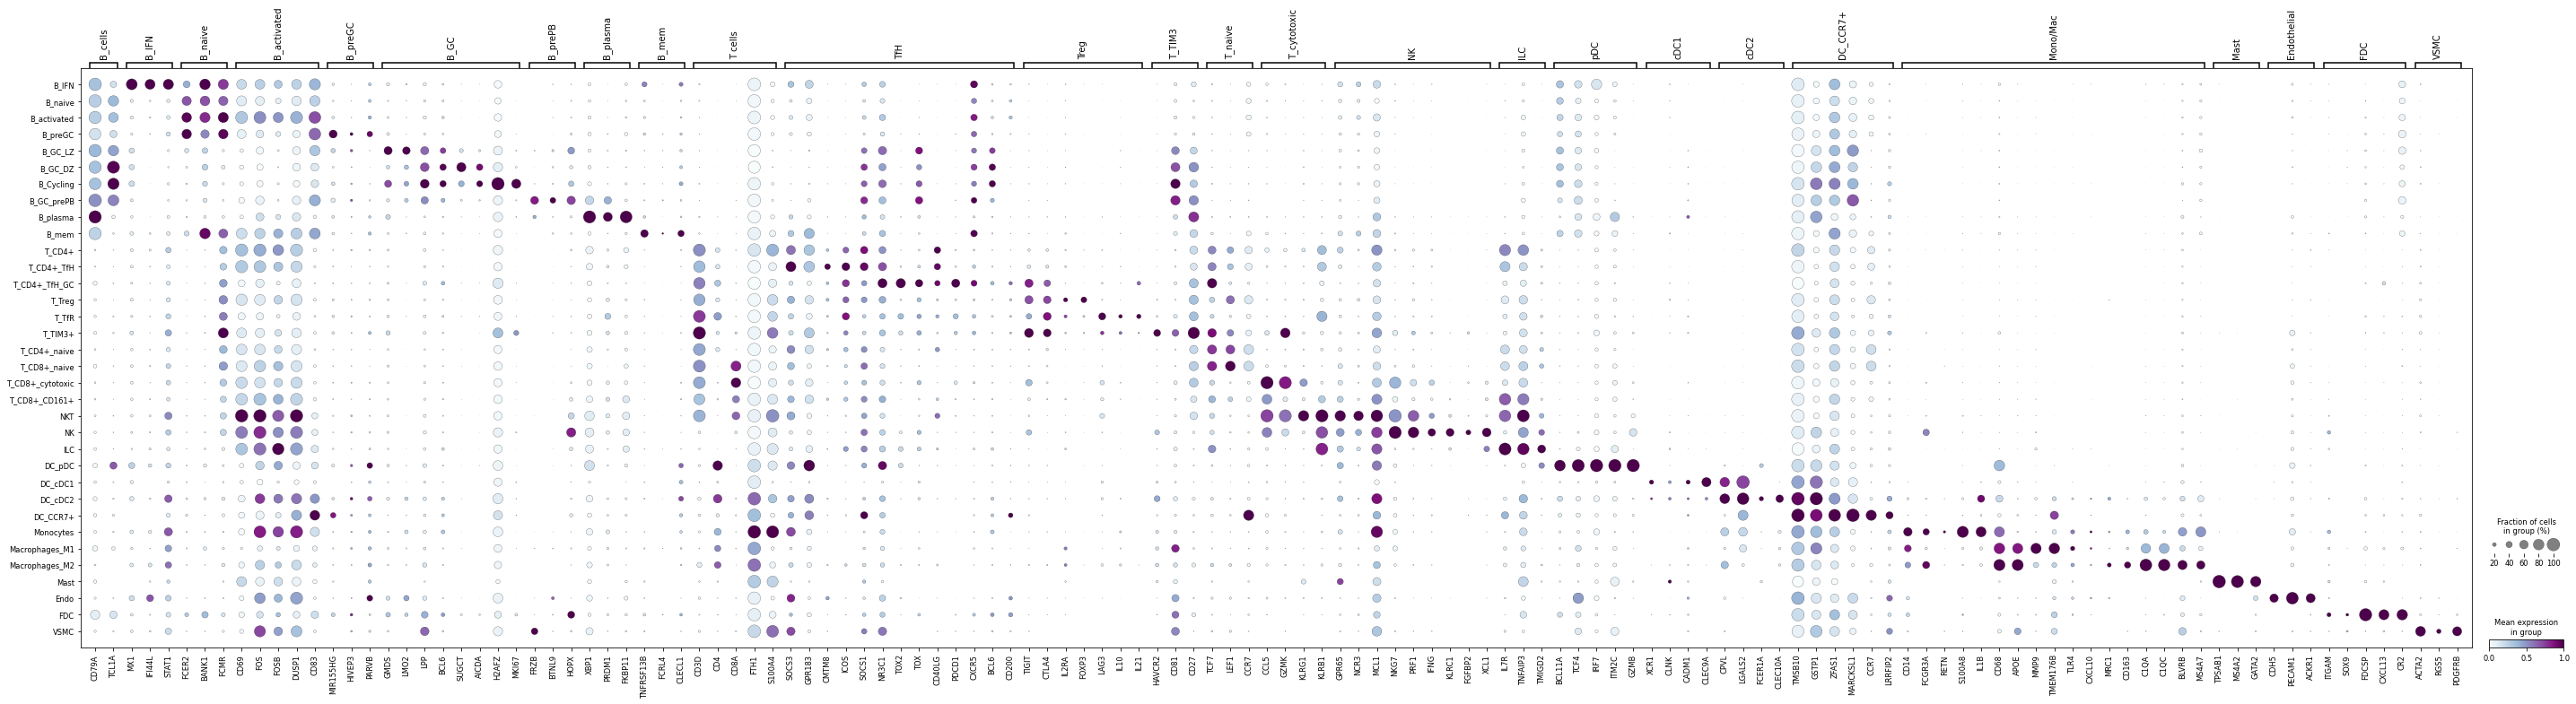

In [144]:
marker_genes_dict = {
    'B_cells': ["CD79A", "TCL1A"],
    'B_IFN': ["MX1","IFI44L", "STAT1"],
    'B_naive': ["FCER2", "BANK1", "FCMR"],
    'B_activated': ['CD69','FOS','FOSB','DUSP1','CD83'],
    'B_preGC': ["MIR155HG", "HIVEP3", "PARVB"],
    'B_GC': ["GMDS", "LMO2", "LPP", "BCL6", "SUGCT", "AICDA", "H2AFZ", "MKI67"],
    'B_prePB': ["FRZB", "BTNL9",  "HOPX"],
    'B_plasma': ["XBP1", "PRDM1",  "FKBP11"],
    'B_mem': ["TNFRSF13B", "FCRL4", "CLECL1"],

'T cells': ["CD3D",  "CD4", "CD8A", "FTH1", "S100A4"],
'TfH': ["SOCS3", "GPR183", "CMTM8","ICOS", "SOCS1", "NR3C1","TOX2", "TOX",
        "CD40LG", "PDCD1", "CXCR5", "BCL6", "CD200"],
'Treg': ["TIGIT", "CTLA4", "IL2RA","FOXP3", "LAG3", "IL10", "IL21"],
'T_TIM3': ["HAVCR2", "CD81", "CD27"],
'T_naive': ['TCF7', "LEF1", "CCR7"],
'T_cytotoxic': ["CCL5",'GZMK',  "KLRG1",  "KLRB1"],
'NK': ["GPR65","NCR3","MCL1", "NKG7","PRF1", "IFNG","KLRC1", "FGFBP2", "XCL1"],
'ILC': ["IL7R", "TNFAIP3",  "TMIGD2"],
'pDC': ["BCL11A",  "TCF4", "IRF7", "ITM2C", "GZMB"],    
'cDC1': ["XCR1", "CLNK", "CADM1", "CLEC9A"],
'cDC2': ['CPVL','LGALS2','FCER1A','CLEC10A',],
'DC_CCR7+': ["TMSB10",   "GSTP1", "ZFAS1", "MARCKSL1","CCR7",  "LRRFIP2"],    
'Mono/Mac': [
              'CD14',"FCGR3A", 'RETN','S100A8', "IL1B", #Mono
                "CD68",'APOE',                          #Mac
                'MMP9',"TMEM176B","TLR4","CXCL10",      #M1
    "MRC1", "CD163", 'C1QA',"C1QC", "BLVRB","MS4A7"     #M2
    ],
'Mast': ["TPSAB1",  "MS4A2","GATA2"],
'Endothelial': ["CDH5","PECAM1", "ACKR1"],
'FDC': ["ITGAM", "SOX9", "FDCSP", "CXCL13", "CR2"],    
'VSMC': ["ACTA2","RGS5", "PDGFRB"],
}

plt.rcParams['figure.figsize'] = [10, 3]
ax = sc.pl.dotplot(adata, marker_genes_dict, groupby='Subset', dendrogram=False, standard_scale='var', log=False, cmap="BuPu" )

In [132]:
tcells = adata[adata.obs['Subset'].isin(['T_CD4+',
'T_CD4+_TfH',
'T_CD4+_TfH_GC',
'T_Treg',
'T_TfR',
'T_TIM3+',
'T_CD4+_naive',
    'T_CD8+_naive',
    'T_CD8+_cytotoxic',
'T_CD8+_CD161+',
'NKT',
'NK',
'ILC'])]

/home/hamish/miniconda3/envs/scvelo/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [133]:
bcells = adata[adata.obs['Subset'].isin(['B_IFN',
'B_naive',
'B_activated',
'B_preGC',
'B_GC_LZ',
'B_GC_DZ',
'B_Cycling',
'B_GC_prePB',
'B_plasma',
'B_mem'])]

/home/hamish/miniconda3/envs/scvelo/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [131]:
nonlymphoidcells = adata[adata.obs['Subset'].isin(['DC_pDC',
'DC_cDC1',
'DC_cDC2',
'DC_CCR7+',
'Monocytes',
'Macrophages_M1',
'Macrophages_M2',
'Mast',
'Endo',
'FDC',
'VSMC'])]

/home/hamish/miniconda3/envs/scvelo/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


/home/hamish/miniconda3/envs/scvelo/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


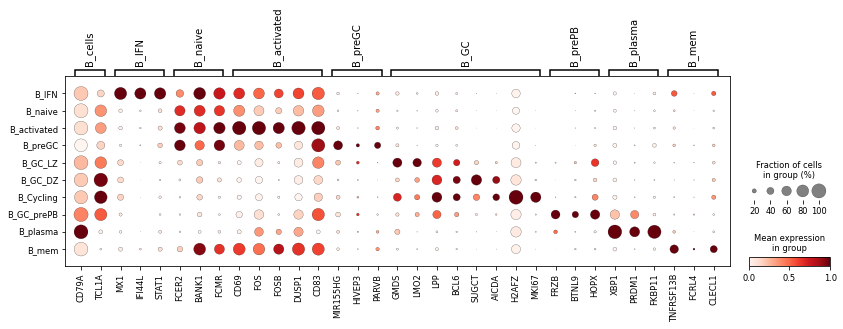

In [139]:
marker_genes_dict = {
    'B_cells': ["CD79A", "TCL1A"],
    'B_IFN': ["MX1","IFI44L", "STAT1"],
    'B_naive': ["FCER2", "BANK1", "FCMR"],
    'B_activated': ['CD69','FOS','FOSB','DUSP1','CD83'],
    'B_preGC': ["MIR155HG", "HIVEP3", "PARVB"],
    'B_GC': ["GMDS", "LMO2", "LPP", "BCL6", "SUGCT", "AICDA", "H2AFZ", "MKI67"],
    'B_prePB': ["FRZB", "BTNL9",  "HOPX"],
    'B_plasma': ["XBP1", "PRDM1",  "FKBP11"],
    'B_mem': ["TNFRSF13B", "FCRL4", "CLECL1"]
}

plt.rcParams['figure.figsize'] = [10, 3]
ax = sc.pl.dotplot(bcells, marker_genes_dict, groupby='Subset', dendrogram=False, standard_scale='var', log=False, cmap="Reds")

/home/hamish/miniconda3/envs/scvelo/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


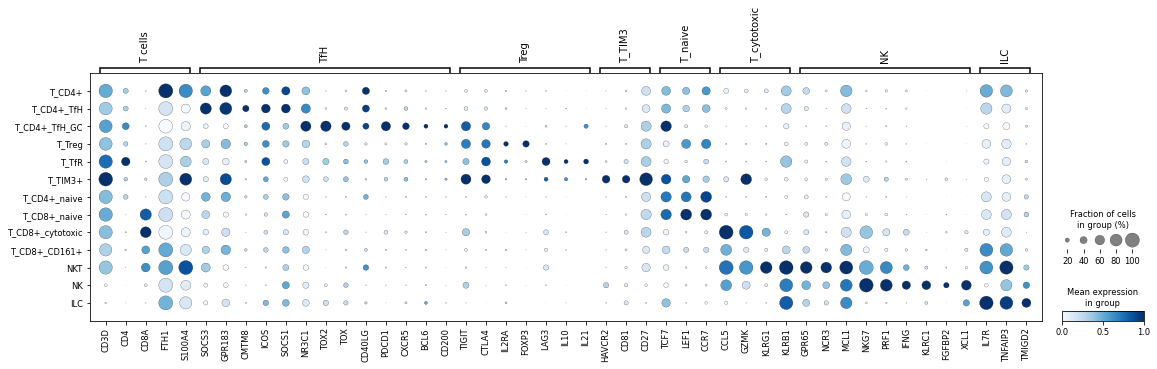

In [137]:
marker_genes_dict = {
'T cells': ["CD3D",  "CD4", "CD8A", "FTH1", "S100A4"],
'TfH': ["SOCS3", "GPR183", "CMTM8","ICOS", "SOCS1", "NR3C1","TOX2", "TOX",
        "CD40LG", "PDCD1", "CXCR5", "BCL6", "CD200"],
'Treg': ["TIGIT", "CTLA4", "IL2RA","FOXP3", "LAG3", "IL10", "IL21"],
'T_TIM3': ["HAVCR2", "CD81", "CD27"],
'T_naive': ['TCF7', "LEF1", "CCR7"],
'T_cytotoxic': ["CCL5",'GZMK',  "KLRG1",  "KLRB1"],
'NK': ["GPR65","NCR3","MCL1", "NKG7","PRF1", "IFNG","KLRC1", "FGFBP2", "XCL1"],
'ILC': ["IL7R", "TNFAIP3",  "TMIGD2"]
}

plt.rcParams['figure.figsize'] = [10, 3]
ax = sc.pl.dotplot(tcells, marker_genes_dict, groupby='Subset', dendrogram=False, standard_scale='var', log=False, cmap="Blues")

/home/hamish/miniconda3/envs/scvelo/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


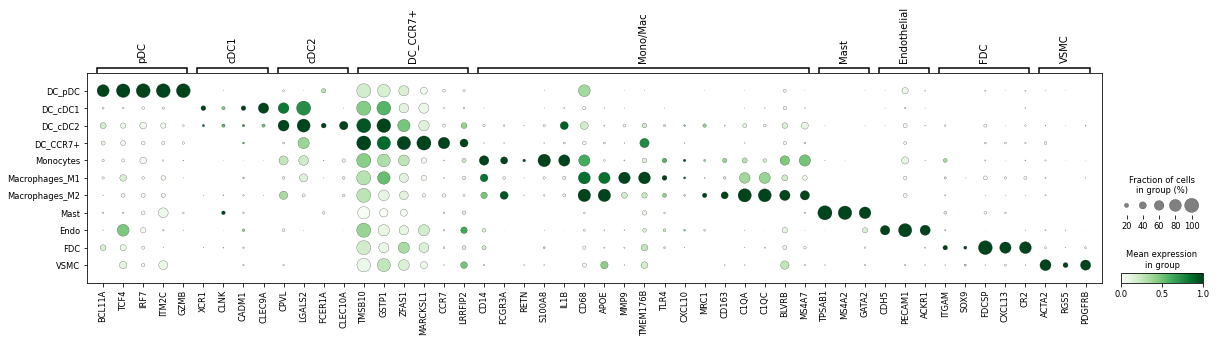

In [138]:
marker_genes_dict = {
    
'pDC': ["BCL11A",  "TCF4", "IRF7", "ITM2C", "GZMB"],    
'cDC1': ["XCR1", "CLNK", "CADM1", "CLEC9A"],
'cDC2': ['CPVL','LGALS2','FCER1A','CLEC10A',],
'DC_CCR7+': ["TMSB10",   "GSTP1", "ZFAS1", "MARCKSL1","CCR7",  "LRRFIP2"],    
'Mono/Mac': [
            'CD14',"FCGR3A", 'RETN','S100A8', "IL1B", #Mono
            "CD68",'APOE',                          #Mac
            'MMP9',"TMEM176B","TLR4","CXCL10",      #M1
            "MRC1", "CD163", 'C1QA',"C1QC", "BLVRB","MS4A7"     #M2
    ],
'Mast': ["TPSAB1",  "MS4A2","GATA2"],
'Endothelial': ["CDH5","PECAM1", "ACKR1"],
'FDC': ["ITGAM", "SOX9", "FDCSP", "CXCL13", "CR2"],    
'VSMC': ["ACTA2","RGS5", "PDGFRB"],
}

plt.rcParams['figure.figsize'] = [10, 3]
ax = sc.pl.dotplot(nonlymphoidcells, marker_genes_dict, groupby='Subset', dendrogram=False, standard_scale='var', log=False, cmap="Greens")

# Only top 2/3 most important per cluster

/home/hamish/miniconda3/envs/scvelo/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


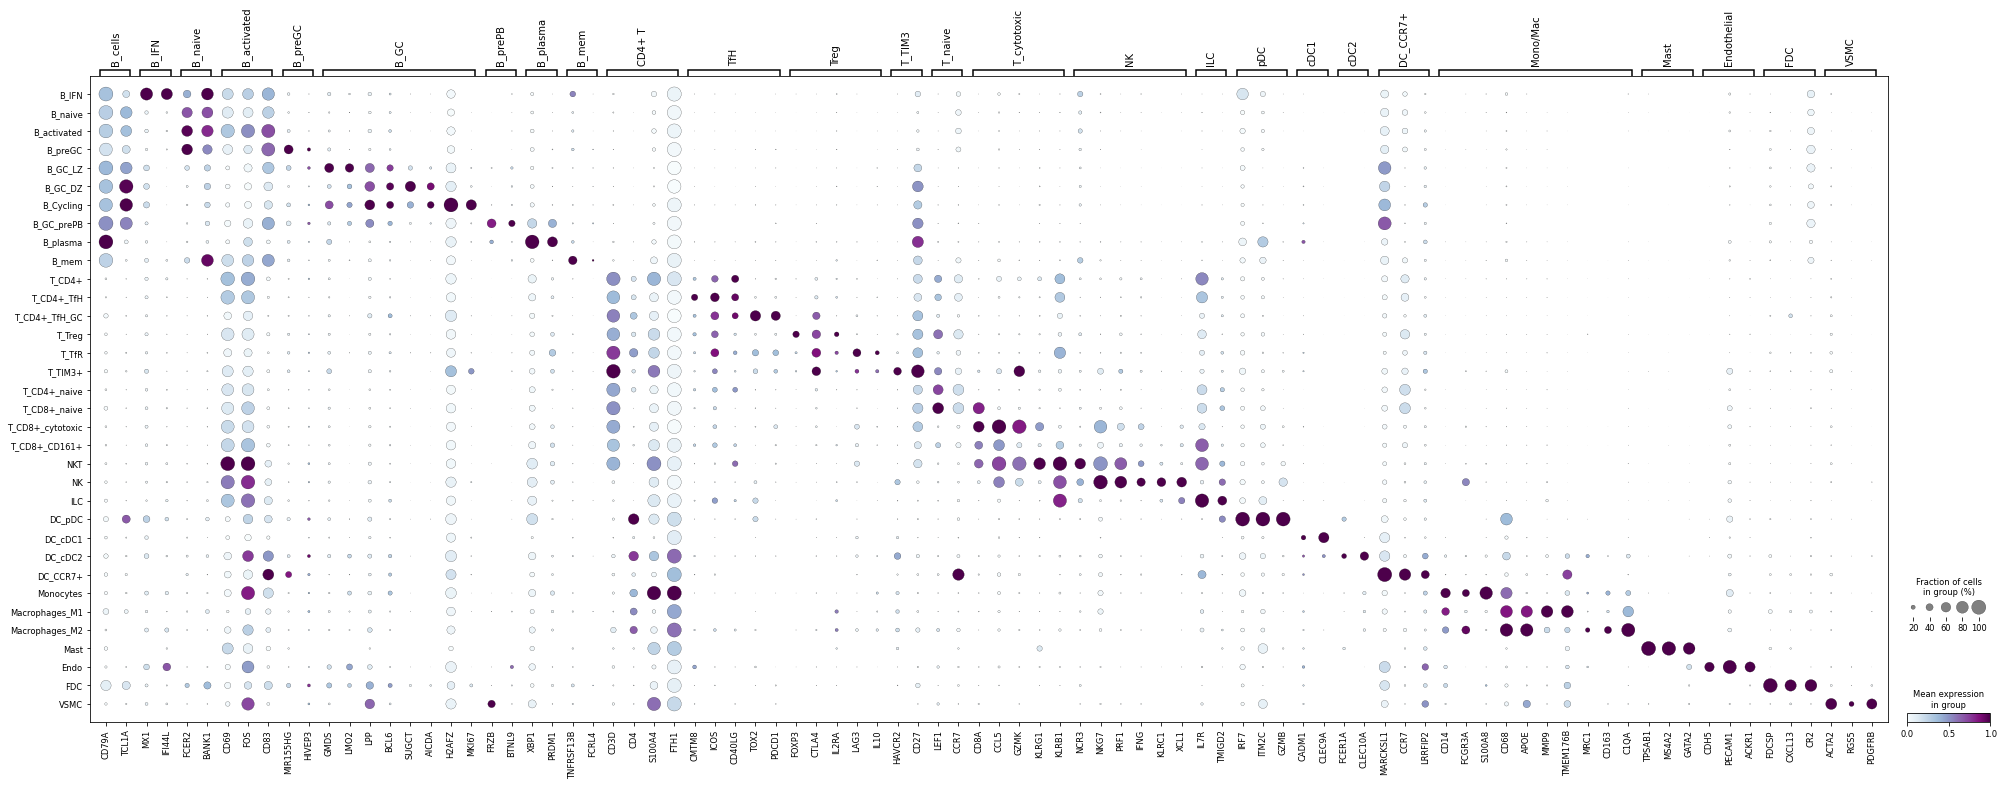

In [166]:
shortlist_marker_genes_dict = {
    'B_cells': ["CD79A", "TCL1A"],
    'B_IFN': ["MX1","IFI44L"],
    'B_naive': ["FCER2", "BANK1"],
    'B_activated': ['CD69','FOS','CD83'],
    'B_preGC': ["MIR155HG", "HIVEP3"],
    'B_GC': ["GMDS", "LMO2", 
             "LPP", "BCL6", 
             "SUGCT", "AICDA", 
             "H2AFZ", "MKI67"],
    'B_prePB': ["FRZB", "BTNL9"],
    'B_plasma': ["XBP1", "PRDM1"],
    'B_mem': ["TNFRSF13B", "FCRL4"],

'CD4+ T': ["CD3D",  "CD4",  
                 "S100A4", "FTH1"],
'TfH': ["CMTM8", "ICOS", "CD40LG","TOX2", "PDCD1"],
'Treg': ["FOXP3","CTLA4", "IL2RA", "LAG3", "IL10"],
'T_TIM3': ["HAVCR2", "CD27"],
'T_naive': ["LEF1", "CCR7"],
'T_cytotoxic': ["CD8A","CCL5",'GZMK',  "KLRG1",  "KLRB1"],
'NK': ["NCR3", "NKG7","PRF1", "IFNG","KLRC1", "XCL1"],
'ILC': ["IL7R", "TMIGD2"],
'pDC': ["IRF7", "ITM2C", "GZMB"],    
'cDC1': ["CADM1", "CLEC9A"],
'cDC2': ['FCER1A','CLEC10A'],
'DC_CCR7+': ["MARCKSL1","CCR7",  "LRRFIP2"],    
'Mono/Mac': [
              'CD14',"FCGR3A", 
                'S100A8', #Mono
                "CD68",'APOE',                          #Mac
                'MMP9',"TMEM176B",#M1
    "MRC1", "CD163", 'C1QA'#M2
    ],
'Mast': ["TPSAB1",  "MS4A2","GATA2"],
'Endothelial': ["CDH5","PECAM1", "ACKR1"],
'FDC': ["FDCSP", "CXCL13", "CR2"],    
'VSMC': ["ACTA2","RGS5", "PDGFRB"]
}

plt.rcParams['figure.figsize'] = [10, 3]
ax = sc.pl.dotplot(adata, shortlist_marker_genes_dict, groupby='Subset', dendrogram=False, standard_scale='var', log=False, cmap="BuPu" )

/home/hamish/miniconda3/envs/scvelo/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


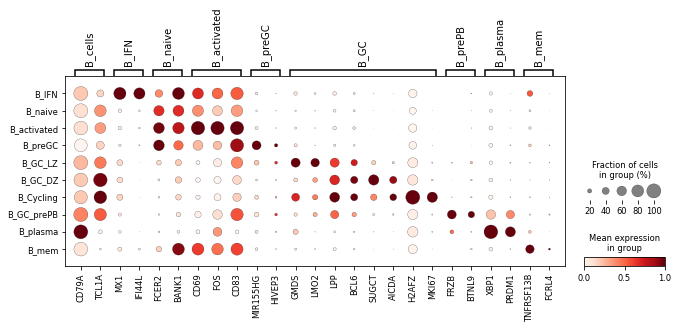

In [158]:
shortlist_marker_genes_dict = {
    'B_cells': ["CD79A", "TCL1A"],
    'B_IFN': ["MX1","IFI44L"],
    'B_naive': ["FCER2", "BANK1"],
    'B_activated': ['CD69','FOS','CD83'],
    'B_preGC': ["MIR155HG", "HIVEP3"],
    'B_GC': ["GMDS", "LMO2", 
             "LPP", "BCL6", 
             "SUGCT", "AICDA", 
             "H2AFZ", "MKI67"],
    'B_prePB': ["FRZB", "BTNL9"],
    'B_plasma': ["XBP1", "PRDM1"],
    'B_mem': ["TNFRSF13B", "FCRL4"],
}

plt.rcParams['figure.figsize'] = [10, 3]
ax = sc.pl.dotplot(bcells, shortlist_marker_genes_dict, groupby='Subset', dendrogram=False, standard_scale='var', log=False, cmap="Reds")

/home/hamish/miniconda3/envs/scvelo/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


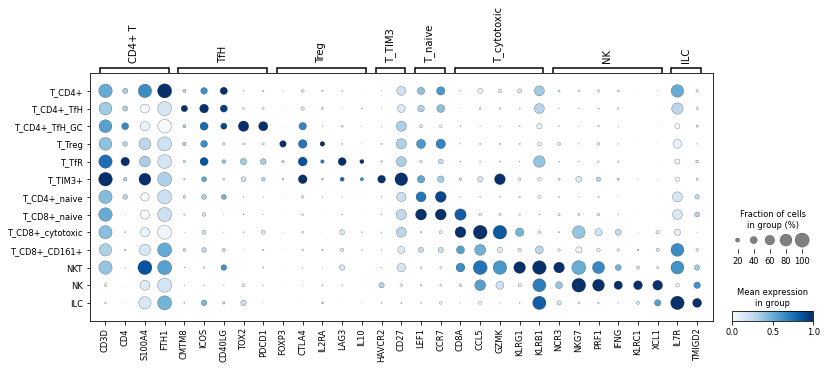

In [160]:
shortlist_marker_genes_dict = {
'CD4+ T': ["CD3D",  "CD4",  
                 "S100A4", "FTH1"],
'TfH': ["CMTM8", "ICOS", "CD40LG","TOX2", "PDCD1"],
'Treg': ["FOXP3","CTLA4", "IL2RA", "LAG3", "IL10"],
'T_TIM3': ["HAVCR2", "CD27"],
'T_naive': ["LEF1", "CCR7"],
'T_cytotoxic': ["CD8A","CCL5",'GZMK',  "KLRG1",  "KLRB1"],
'NK': ["NCR3", "NKG7","PRF1", "IFNG","KLRC1", "XCL1"],
'ILC': ["IL7R", "TMIGD2"],

}
plt.rcParams['figure.figsize'] = [10, 3]
ax = sc.pl.dotplot(tcells, shortlist_marker_genes_dict, groupby='Subset', dendrogram=False, standard_scale='var', log=False, cmap="Blues")

/home/hamish/miniconda3/envs/scvelo/lib/python3.6/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


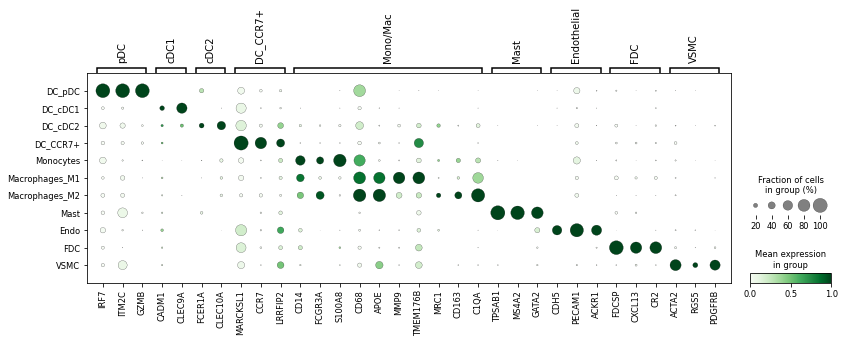

In [161]:
shortlist_marker_genes_dict = {
'pDC': ["IRF7", "ITM2C", "GZMB"],    
'cDC1': ["CADM1", "CLEC9A"],
'cDC2': ['FCER1A','CLEC10A'],
'DC_CCR7+': ["MARCKSL1","CCR7",  "LRRFIP2"],    
'Mono/Mac': [
              'CD14',"FCGR3A", 
                'S100A8', #Mono
                "CD68",'APOE',                          #Mac
                'MMP9',"TMEM176B",#M1
    "MRC1", "CD163", 'C1QA'#M2
    ],
'Mast': ["TPSAB1",  "MS4A2","GATA2"],
'Endothelial': ["CDH5","PECAM1", "ACKR1"],
'FDC': ["FDCSP", "CXCL13", "CR2"],    
'VSMC': ["ACTA2","RGS5", "PDGFRB"]
}

plt.rcParams['figure.figsize'] = [10, 3]
ax = sc.pl.dotplot(nonlymphoidcells, shortlist_marker_genes_dict, groupby='Subset', dendrogram=False, standard_scale='var', log=False, cmap="Greens")